In [139]:
import numpy as np
import rtlsdr
import pylab as plt

from scipy.ndimage import median_filter


In [156]:
# Stash params here for now
sample_rate = int(1.024e6)
len_window = sample_rate*3

thr=0.4

# Beeps are about 35000 samples, which is 0.017 * sample_rate?
# Suggests sample rate is double the one above...

centre_freq = 160_270_968
carrier_freq = 160_707_760
read_size = 65536
gain = 7.7

In [ ]:
#samples = np.load('log_v15.npy')

In [146]:
# Suppress all samples below a threshold 
# TODO: set threshold by SNR
def thresholded_samples(samples,thr):
    return np.where(samples<thr,0,samples)

def thresholded_indices(samples,thr):
    return np.where(samples>thr)

def median_filter_(samples,width):
    return median_filter(samples,size=width)

def snr(samples, rises, falls):
    snr_db=0
    for i in range(1,len(rises)):
        signal_power = np.var(samples[rises[i]:falls[i]])
        noise_power = np.var(samples[falls[i-1]:rises[i]])
        snr_db += 10 * np.log10(signal_power/noise_power)
    return snr_db/(len(rises)-1)


In [112]:
# Note magic parameter... width of a beep -- sort if needed!
# This might be more noise resistant. Or not.
from scipy.signal import find_peaks
def find_beeps_old(samples,thr):
    s = thresholded_samples(np.abs(samples),thr)
    peaks = find_peaks(s,distance=35000)[0]
    s = median_filter(np.abs(samples),100)
    s = thresholded_samples(s,thr)
    rises = np.copy(peaks)
    falls = np.copy(peaks)

    for p in range(len(peaks)):
        #rises[p] = peaks[p]
        while s[rises[p]]>0 & rises[p]<0:
            rises[p] -= 1
        #falls[p] = peaks[p]
        while s[falls[p]]>0 & falls[p]<len(s)-1:
            falls[p] += 1

    # TODO: Squash any misdetections
    
    print(peaks)

    for i in range(len(rises)):
        print((falls[i]-rises[i])/sample_rate)
    for i in range(1,len(rises)):
        print(60/(rises[i]-falls[i-1])*sample_rate)
find_beeps(samples,0.4)

In [ ]:
def find_beeps(samples,thr):
    # TODO: threshold needs to be set properly
    # TODO: how long a window should this get?
    s = median_filter(np.abs(samples),size=100)
    s = np.where(s<thr,0,1)
    t = s-np.roll(s,1)
    rises = np.where(t>0)[0]
    falls = np.where(t<0)[0]
    print("No beeps: ",len(rises))
    
    # TODO: Squash any misdetections
    # E.g., beep is wrong length (noise?)
    todelete = []
    for i in range(len(rises)):
        len_beep = (falls[i]-rises[i])/sample_rate
        print(len_beep)
        if np.abs(len_beep-0.0347)>0.01:
            todelete.append(i)
    rises = np.delete(rises,todelete)
    falls = np.delete(falls,todelete)
    print(todelete)
    #print(rises)
    #print(falls)
    return rises,falls
r,f = find_beeps(samples,0.4)
print(r,f)

In [176]:
# Convenience function to use Al's prerecorded data
# Note: already fft'd
def test_from_file(filename):
    samples = np.load(filename,allow_pickle=True)
    rises = []
    falls = []
    for i in range(0,len(samples),len_window):
        r, f = find_beeps(samples[i:i+len_window],thr)
        rises.append(r+i*len_window)
        falls.append(f+i*len_window)
        
test_from_file('log_v15.npy')
print(rises)
print(falls)
# Get the pulse rate
for i in range(1,len(rises)):
    BPM = (60/(rises[i]-falls[i-1])*sample_rate)
    print(BPM)
    


No beeps:  3
0.00181640625
0.03471875
0.03474609375
No beeps:  1
0.03473828125
No beeps:  1
0.03476953125
No beeps:  0
[   1595  125967 2767576 5430005 8112572]
[   1860  160511 2802373 5464658 8147484]
495.05668495733516
23.56673117087606
23.38226966333185
23.203170495718517


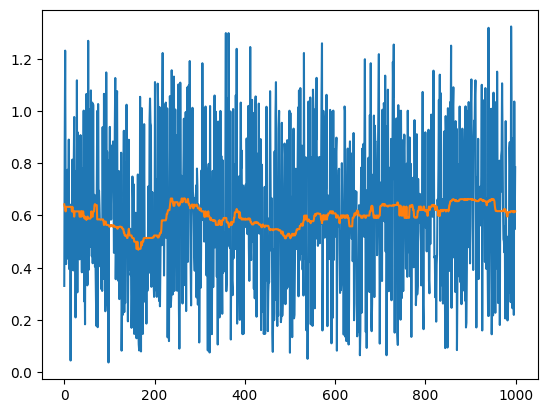

In [127]:
plt.plot(np.abs(samples)[:1000])
plt.plot(median_filter(np.abs(samples),100)[:1000])

In [147]:
snr(samples,r,f)


24.59940066869817

In [ ]:
# Same for reading from a buffer
# Don't forget to fft
def test_from_buffer():
    todo...

/home/marslast/.pyenv/versions/3.9.16/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


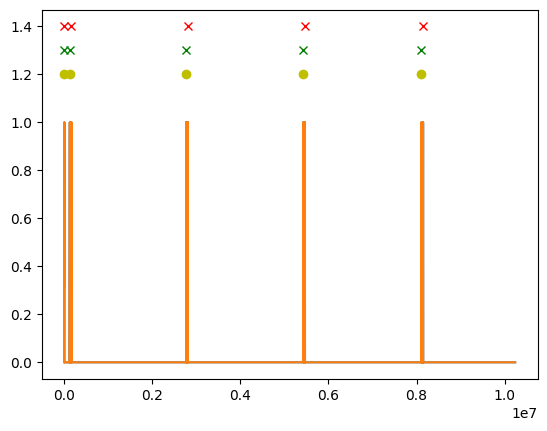

In [117]:
plt.plot(thresholded_samples(np.abs(samples),0.3));
#plt.plot(x[0],np.ones(np.shape(x[0])),'*');
#plt.plot(y,1.2*np.ones(np.shape(y)),'o');
plt.plot(peaks,1.2*np.ones(np.shape(peaks)),'yo');
plt.plot(rises,1.3*np.ones(np.shape(peaks)),'gx');
plt.plot(falls,1.4*np.ones(np.shape(falls)),'rx');
plt.plot(s)


In [109]:
1.024e6 * 0.017 *2

34816.0